# NRL Feature Map and Machine Learning Model

## Imports

In [ ]:
!pip install scikit-learn
!pip install tensorflow
!pip install numpy
!pip install pandas

In [1]:
import pandas as pd 
import json
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Extracting Data from the JSON

In [2]:
teams = ["Broncos", "Roosters", "Wests Tigers", "Rabbitohs", "Storm", "Eels", "Raiders", "Knights", "Dragons", "Sea Eagles", "Panthers", "Sharks", "Bulldogs", "Dolphins", "Titans", "Cowboys", "Warriors"]
variables =["Year", "Win", "Defense", "Attack", "Margin", "Home", "Versus",  "Round"]
years =  [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2022, 2023]

In [3]:
years_arr = {}
with open('nrl_data_multi_years_2.json', 'r') as file:
    data = json.load(file)
    data = data['NRL']
    for year in years:
        years_arr[year] = data[years.index(year)][str(year)]
    

In [4]:
df = pd.DataFrame(columns=[f"{team} {variable}" for team in teams for variable in variables])


In [69]:
all_store = []
for year in years:
    for round in range(0, 26):
        try:
            round_data = years_arr[year][round][str(round+1)]
            
            # Create an empty feature array 
            round_store = np.zeros([len(teams)*len(variables)], dtype=int)
            round_teams = []
            for game in round_data:
                h_team = game['Home']
                h_score = int(game['Home_Score'])
                a_team = game['Away']
                a_score = int(game['Away_Score'])
                
                # win or lose
                h_team_win = h_score >= a_score
                a_team_win = a_score >= h_score
                
                # home
                h_home = 1
                a_home = 0
                
                # versus
                h_versus = teams.index(a_team)
                a_versus = teams.index(h_team)
                
                # Defense (points let in)
                h_team_defense = a_score
                a_team_defense = h_score  
                
                # Attack Points scored
                h_team_attack = h_score 
                a_team_attack = a_score   
                
                # Margin
                h_team_margin =  h_score-a_score   
                a_team_margin =  a_score-h_score        
                
                # Keep track of which teams played to work out which teams had a bye 
                round_teams.append(h_team)
                round_teams.append(a_team)
                
                
                # Find the index of the team in the overaching array 
                a_team_idx = teams.index(a_team)
                h_team_idx = teams.index(h_team)
                
                # Feature map index
                a_team_idx_fm = a_team_idx*len(variables)
                h_team_idx_fm = h_team_idx*len(variables)
                
                # input(round_store)
                # input(a_team_idx_fm)
                # populate the data
                round_store[a_team_idx_fm] = year
                round_store[a_team_idx_fm+1] = a_team_win
                round_store[a_team_idx_fm+2] = a_team_defense
                round_store[a_team_idx_fm+3] = a_team_attack
                round_store[a_team_idx_fm+4] = a_team_margin
                round_store[a_team_idx_fm+5] = a_home
                round_store[a_team_idx_fm+6] = a_versus
                round_store[a_team_idx_fm+7] = round+1
                round_store[h_team_idx_fm] = year
                round_store[h_team_idx_fm+1] = h_team_win
                round_store[h_team_idx_fm+2] = h_team_defense
                round_store[h_team_idx_fm+3] = h_team_attack
                round_store[h_team_idx_fm+4] = h_team_margin
                round_store[h_team_idx_fm+5] = h_home
                round_store[h_team_idx_fm+6] = h_versus
                round_store[h_team_idx_fm+7] = round+1
                
            # input(round_teams)
            bye_teams = list(set(teams) - set(round_teams))
            for bye_team in bye_teams:
                b_team_idx = teams.index(bye_team)
                b_team_idx_fm = b_team_idx*len(variables)
                round_store[b_team_idx_fm] = year
                round_store[b_team_idx_fm+1] = -1
                round_store[b_team_idx_fm+2] = -1
                round_store[b_team_idx_fm+3] = -1
                round_store[b_team_idx_fm+4] = 0
                round_store[b_team_idx_fm+5] = -1
                round_store[b_team_idx_fm+6] = -1
                round_store[b_team_idx_fm+7] = round+1
                
            all_store.append(round_store)
            # Create an array with the same size as the DataFrame

            # Add the new row to the DataFrame using loc
            df.loc[len(df)] = round_store
        except:
            pass
df

,Broncos Year,Broncos Win,Broncos Defense,Broncos Attack,Broncos Margin,Broncos Home,Broncos Versus,Broncos Round,Roosters Year,Roosters Win,...,Cowboys Versus,Cowboys Round,Warriors Year,Warriors Win,Warriors Defense,Warriors Attack,Warriors Margin,Warriors Home,Warriors Versus,Warriors Round
0,2008,1,12,48,36,1,10,1,2008,1,...,14,1,2008,0,32,18,-14,0,4,1
1,2008,1,14,20,6,0,1,2,2008,0,...,2,2,2008,1,16,30,14,1,5,2
2,2008,1,2,36,34,1,15,3,2008,1,...,0,3,2008,0,52,6,-46,0,9,3
3,2008,0,28,8,-20,0,4,4,2008,1,...,5,4,2008,1,20,26,6,1,7,4
4,2008,1,22,34,12,0,7,5,2008,1,...,8,5,2008,1,16,36,20,1,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,2023,0,18,12,-6,1,14,17,2023,0,...,3,17,2023,1,18,48,30,0,8,17
6002,2023,1,16,24,8,1,13,18,2023,0,...,2,18,2023,0,28,6,-22,1,3,18
6003,2023,-1,-1,-1,0,-1,-1,19,2023,-1,...,-1,19,2023,1,10,46,36,0,5,19
6004,2023,1,24,44,20,0,12,20,2023,0,...,9,20,2023,1,12,44,32,1,11,20


### Creating the Feature Map

In [70]:
GAME_HISTORY = 3

def get_game_history(year, round_, team):
    # Filter by year
    filtered_df = df[df[team + " Year"] == year]
    # # Remove all byes
    filtered_df = filtered_df.iloc[round_-GAME_HISTORY-1:round_-1] 
    
    byes = len(filtered_df[filtered_df[team + " Win"] == -1])
    
    filtered_df = filtered_df[filtered_df[team + " Win"] != -1]
    
    
    win = filtered_df[team+ " Win"].mean()
    defense = filtered_df[team+ " Defense"].median()
    attack = filtered_df[team+ " Attack"].median()
    margin = filtered_df[team+ " Margin"].median()
    
    defense_mean = filtered_df[team+ " Defense"].mean()
    attack_mean = filtered_df[team+ " Attack"].mean()
    margin_mean = filtered_df[team+ " Margin"].mean()
    
    
    games_at_home = filtered_df[team+ " Home"].mean()
    
    return win, defense, attack, margin, byes, games_at_home, defense_mean, attack_mean, margin_mean, year
    

### Creating the Learning Data / extending upon the feature map

In [71]:
X = []
y = [] 
# Input: Team, Other Team Team Stats, Other Team Stats
# Output: Team, win/lose, other team, win/lose

for team in teams:
    # Skip the game history as we dont want to break the calibration
    versed_teams = df[team+ " Versus"]
    wins = df[team+ " Win"]
    rounds = df[team+ " Round"]
    years = df[team+ " Year"]
    margins = df[team+ " Margin"]
    
    c_team_idx = teams.index(team)
    
    
    
    for versed_team, win, round, year, margin in zip(versed_teams, wins, rounds, years, margins):
        # Skip all byes  or games with no momentum
        if win == -1 or round <= GAME_HISTORY:
            continue
        
        
        # dosent take into account for ties, look into this harder later 
        winning_team = -1
        if win == 1:
            v_win_ = 0
            winning_team = c_team_idx
        else:
            v_win_ = 1
            winning_team = versed_team
            
        if abs(margin) > 13:
            big_win = 1
        else:
            big_win = 0
        
        # Current team, vsed team, who wins, current_team_stats, vsed_team_stats
        X.append([c_team_idx, versed_team, *get_game_history(year, round, team), *get_game_history(year, round, teams[versed_team])])
        y.append([c_team_idx, versed_team, win, v_win_, big_win])


### Training the Data

In [66]:
# Create a Random Forest Regressor model
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.3, shuffle=True)


# Convert lists to NumPy arrays
X_train, X_val, y_train, y_val = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Create a neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout layer to reduce overfitting
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(5))

# Training loop to track R-squared scores on both training and validation sets
num_epochs = 1000  # You can adjust the number of epochs as needed
# Define a learning rate schedule
initial_learning_rate = 0.00001
final_learning_rate = 0.001
batch_size = 32
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/num_epochs)
steps_per_epoch = int(len(X_train_scaled)/batch_size)

lr_schedule = ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)
previous_loss = None
no_loss_change_epochs = 0
loss_change_threshold = 1e-5

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse')

# Lists to store the R-squared scores during training
train_r2_scores = []
val_r2_scores = []
train_losses = []  


for epoch in range(num_epochs):
    # Train the model on the training data
    history = model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=1, verbose=2)
    
    # Calculate R-squared scores on the training and validation sets
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Store the R-squared scores for each epoch
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    
    train_loss = history.history['loss'][0]
    train_losses.append(train_loss)
    
    if previous_loss is not None and abs(previous_loss - train_loss) < loss_change_threshold:
        no_loss_change_epochs += 1
    else:
        no_loss_change_epochs = 0
    
    # Set the current loss as the previous loss for the next epoch
    previous_loss = train_loss
    
    # If there have been no loss changes for a certain number of consecutive epochs, stop training
    if no_loss_change_epochs >= 5:
        print(f"Training stopped early at epoch {epoch + 1} due to no significant loss change.")
        break
    

# Final R-squared scores
final_train_r2 = train_r2_scores[-1]
final_val_r2 = val_r2_scores[-1]

print(f"Final Training R-squared: {final_train_r2:.4f}")
print(f"Final Validation R-squared: {final_val_r2:.4f}")

74/74 - 3s - loss: 39.2741 - 3s/epoch - 36ms/step
32/32 [==============================] - 0s 3ms/step
74/74 - 1s - loss: 38.9625 - 623ms/epoch - 8ms/step
32/32 [==============================] - 0s 3ms/step
74/74 - 1s - loss: 38.7286 - 823ms/epoch - 11ms/step
32/32 [==============================] - 0s 4ms/step
74/74 - 1s - loss: 38.4951 - 588ms/epoch - 8ms/step
32/32 [==============================] - 0s 5ms/step
74/74 - 1s - loss: 38.2298 - 675ms/epoch - 9ms/step
32/32 [==============================] - 0s 3ms/step
74/74 - 1s - loss: 37.8170 - 616ms/epoch - 8ms/step
32/32 [==============================] - 0s 3ms/step
74/74 - 0s - loss: 37.5919 - 319ms/epoch - 4ms/step
32/32 [==============================] - 0s 3ms/step
74/74 - 1s - loss: 37.1667 - 541ms/epoch - 7ms/step
32/32 [==============================] - 0s 3ms/step
74/74 - 0s - loss: 36.9014 - 462ms/epoch - 6ms/step
32/32 [==============================] - 0s 6ms/step
74/74 - 1s - loss: 36.6421 - 635ms/epoch - 9ms/step
32/3

#### Visualising the ML Model

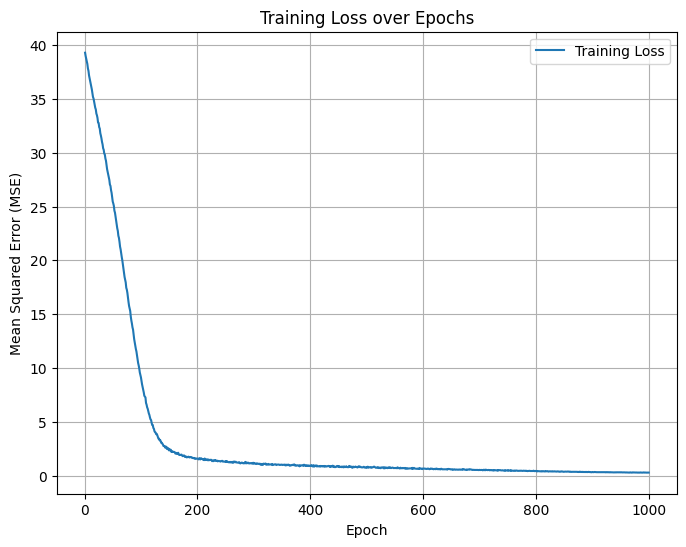

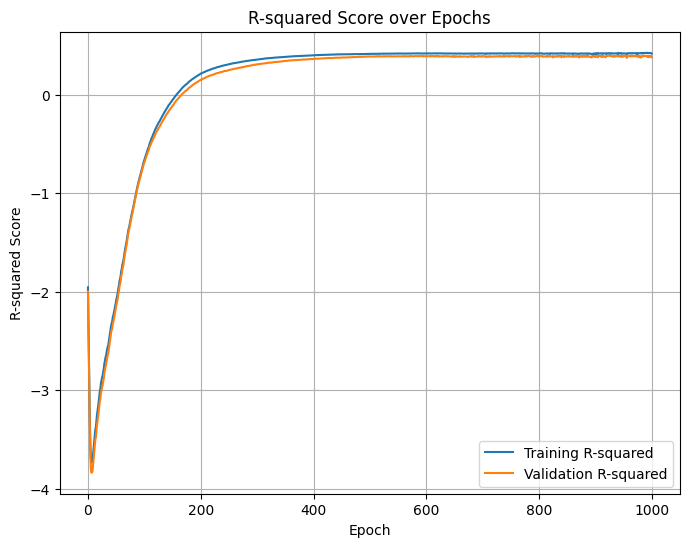

32/32 [==============================] - 0s 2ms/step


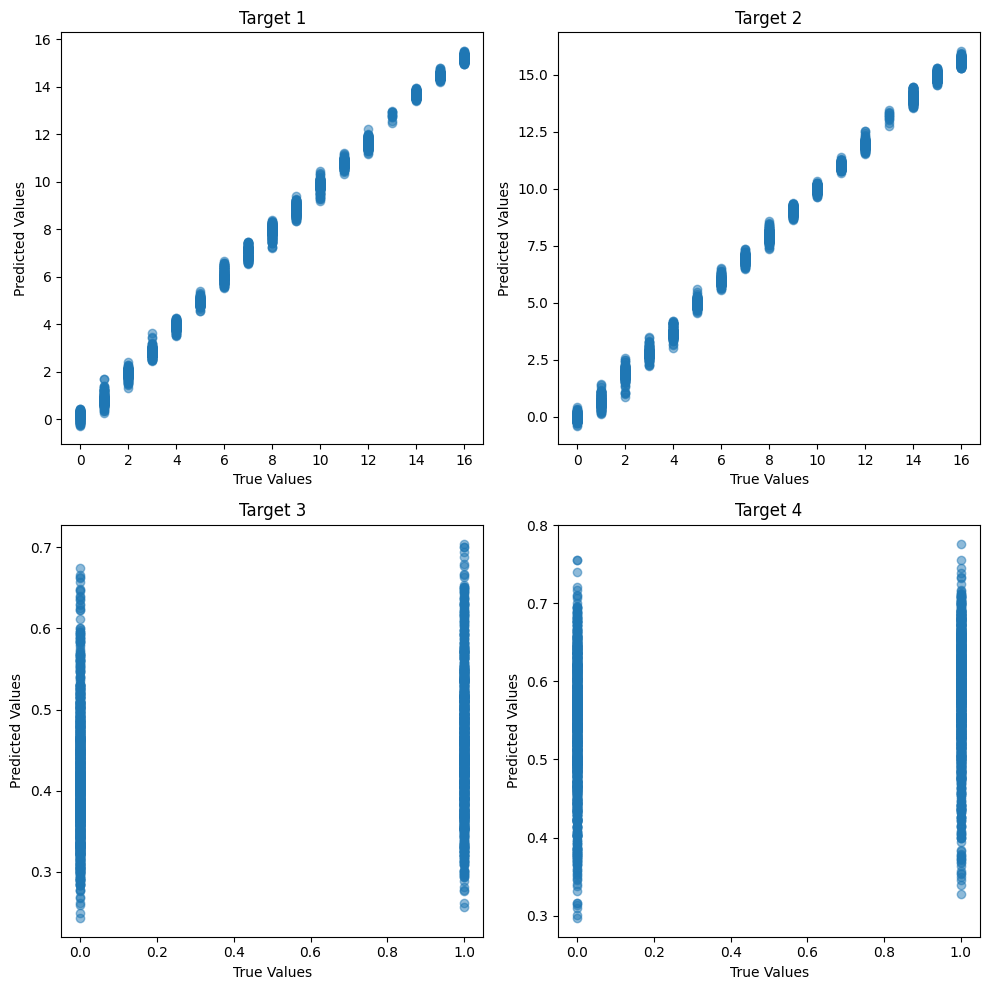

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting R-squared scores
plt.figure(figsize=(8, 6))
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared Score')
plt.title('R-squared Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of true vs. predicted values
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(y_train[:, 0], y_train_pred[:, 0], alpha=0.5)
axs[0, 0].set_title('Target 1')
axs[0, 1].scatter(y_train[:, 1], y_train_pred[:, 1], alpha=0.5)
axs[0, 1].set_title('Target 2')
axs[1, 0].scatter(y_train[:, 2], y_train_pred[:, 2], alpha=0.5)
axs[1, 0].set_title('Target 3')
axs[1, 1].scatter(y_train[:, 3], y_train_pred[:, 3], alpha=0.5)
axs[1, 1].set_title('Target 4')

for ax in axs.flat:
    ax.set(xlabel='True Values', ylabel='Predicted Values')

plt.tight_layout()
plt.show()

### Testing the Prediction

In [68]:
# teams = ["Broncos", "Roosters", "Wests Tigers", "Rabbitohs", "Storm", "Eels", "Raiders", "Knights", "Dragons", "Sea Eagles", "Panthers", "Sharks", "Bulldogs", "Dolphins", "Titans", "Cowboys", "Warriors"]


wkd_matches = [["Broncos", "Roosters"], ["Wests Tigers", "Rabbitohs"], ["Storm", "Eels"], ["Raiders", "Knights"], ["Dragons", "Sea Eagles"], ["Panthers", "Sharks"], ["Bulldogs", "Dolphins"], ["Titans", "Cowboys"]]

# wkd_matches = [["Dragons", "Wests Tigers"], ["Warriors", "Raiders"], ["Rabbitohs", "Broncos"], ["Titans", "Roosters"], ["Knights", "Storm"], ["Cowboys", "Eels"], ["Panthers", "Bulldogs"], ["Sharks", "Sea Eagles"]]

for wkd_match in wkd_matches:

    team_1 = int(teams.index(wkd_match[0]))
    team_2 = int(teams.index(wkd_match[1]))

    pred_in_2 = [team_1, team_2,  *get_game_history(2023, 22, teams[int(team_1)]), *get_game_history(2023, 22, teams[int(team_2)])]

    predictions = model.predict([pred_in_2], verbose=0)
    predictions = predictions[0]
    if predictions[2] > predictions[3]:
        print(f"{teams[team_1]} wins\t\t {teams[team_1]}: {predictions[2]:.4f}\t{teams[team_2]}: {predictions[3]:.4f}\t\tBig Win {predictions[4]}")
    else:
        print(f"{teams[team_2]} wins\t\t {teams[team_1]}: {predictions[2]:.4f}\t{teams[team_2]}: {predictions[3]:.4f}\t\tBig Win {predictions[4]}")


Broncos wins		 Broncos: 1.7690	Roosters: 0.4930		Big Win -0.9053283929824829
Wests Tigers wins		 Wests Tigers: 1.8279	Rabbitohs: 0.5203		Big Win -0.9798415899276733
Storm wins		 Storm: 1.8197	Eels: 0.5718		Big Win -0.9767285585403442
Raiders wins		 Raiders: 1.8685	Knights: 0.5711		Big Win -0.9952212572097778
Dragons wins		 Dragons: 1.8858	Sea Eagles: 0.6570		Big Win -1.0091525316238403
Panthers wins		 Panthers: 1.9956	Sharks: 0.5875		Big Win -1.0300654172897339
Bulldogs wins		 Bulldogs: 2.1288	Dolphins: 0.5294		Big Win -1.1056172847747803
Titans wins		 Titans: 2.2332	Cowboys: 0.4547		Big Win -1.1341997385025024
